In [18]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import pynrc
from pynrc import nrc_utils          # Variety of useful functions and classes
from pynrc.obs_nircam import obs_hci # High-contrast imaging observation class

# Progress bar
from tqdm.auto import tqdm, trange

# Disable informational messages and only include w

In [19]:
# Define 2MASS Ks bandpass and source information
bp_k = pynrc.bp_2mass('k')

# Science         source,  dist, age, sptype, Teff, [Fe/H], log_g, mag, band
args_sources = [('HD 141569A', 111, 5.,  'A2V', 9750, 0., 4.35, 6.82, bp_k)]

# References     source,     sptype, Teff, [Fe/H], log_g, mag, band
ref_sources = [('HD 140986', 'K0III', 4800, -0.01, 3.0, 3.643, bp_k)]


name_sci, dist_sci, age, spt_sci, Teff_sci, feh_sci, logg_sci, mag_sci, bp_sci = args_sources[0]
name_ref, spt_ref, Teff_ref, feh_ref, logg_ref, mag_ref, bp_ref = ref_sources[0]

# For the purposes of simplicity, we will use pynrc.stellar_spectrum()
sp_sci = pynrc.stellar_spectrum(spt_sci, mag_sci, 'vegamag', bp_sci,
                                 Teff=Teff_sci, metallicity=feh_sci, log_g=logg_sci)
sp_sci.name = name_sci

# And the refernece source
sp_ref = pynrc.stellar_spectrum(spt_ref, mag_ref, 'vegamag', bp_ref,
                                 Teff=Teff_ref, metallicity=feh_ref)
sp_ref.name = name_ref




In [20]:
# The initial call make take some time, as it will need to generate coefficients
# to calculate PSF variations across wavelength, WFE drift, and mask location
filt, mask, pupil = ('F360M',  'MASK335R', 'CIRCLYOT')
wind_mode, subsize = ('WINDOW', 320)
fov_pix, oversample = (321, 2)

obs = pynrc.obs_hci(sp_sci, dist_sci, sp_ref=sp_ref, use_ap_info=False,
                    filter=filt, image_mask=mask, pupil_mask=pupil,
                    wind_mode=wind_mode, xpix=subsize, ypix=subsize,
                    fov_pix=fov_pix, oversample=oversample, large_grid=True)


# Set default WFE drift values between Roll1, Roll2, and Ref

# WFE drift amount between rolls
obs.wfe_roll_drift = 2

# Drift amount between Roll 1 and Reference.
obs.wfe_ref_drift = 5

# Update both the science and reference observations
obs.update_detectors(read_mode='DEEP8', ngroup=12, nint=17, verbose=True)
obs.gen_ref_det(read_mode='BRIGHT1', ngroup=24, nint=9 ) #Note: I don't know if there's a way to simulate reference dithers and 

# Create pointing offset with a random seed for reproducibility
obs.gen_pointing_offsets(rand_seed=1234, verbose=True)

# Cycle through a few WFE drift values
wfe_list = [0,5,10]

# PA values for each roll
PA1, PA2 = (85,95)

# A dictionary of HDULists
hdul_dict = {}
for wfe_drift in tqdm(wfe_list):
    # Assume drift between Roll1 and Roll2 is 2 nm WFE
    wfe_roll_drift = 0 if wfe_drift<2 else 2
    hdulist = obs.gen_roll_image(PA1=PA1, PA2=PA2,
                                 wfe_ref_drift=wfe_drift, wfe_roll_drift=wfe_roll_drift)
    hdul_dict[wfe_drift] = hdulist

nsig = 5
roll_angle = np.abs(PA2 - PA1)

curves = []
for wfe_drift in tqdm(wfe_list):
    # Assume drift between Roll1 and Roll2 is 2 nm WFE
    wfe_roll_drift = 0 if wfe_drift<2 else 2

    # Generate contrast curves
    result = obs.calc_contrast(roll_angle=roll_angle, nsig=nsig,
                               wfe_ref_drift=wfe_drift, wfe_roll_drift=wfe_roll_drift,
                               xyoff_roll1=(0,0), xyoff_roll2=(0,0), xyoff_ref=(0,0))
    curves.append(result)




New Ramp Settings
  read_mode  :    DEEP8
  nf         :        8
  nd2        :       12
  ngroup     :       12
  nint       :       17
New Detector Settings
  wind_mode  :   WINDOW
  xpix       :      320
  ypix       :      320
  x0         :     1237
  y0         :     1512
New Ramp Times
  t_group    :   21.381
  t_frame    :    1.069
  t_int      :  243.741
  t_int_tot1 :  244.830
  t_int_tot2 :  244.830
  t_exp      : 4143.599
  t_acq      : 4162.111
Pointing Info
  sgd_type   : None
  slew_std   : 5
  fsm_std    : None
  roll1      : [0.00370446 0.0007631 ]
  roll2      : [0.00431872 0.0145655 ]
  ref        : [-0.00801918  0.0003205 ]


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

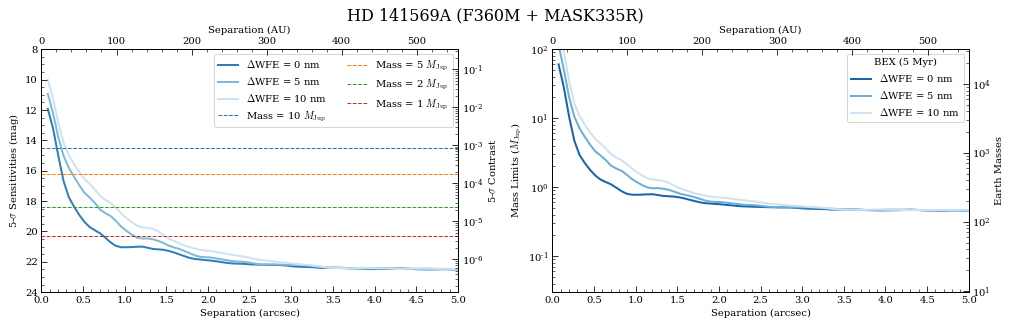

In [21]:
from pynrc.nb_funcs import plot_contrasts, plot_planet_patches, plot_contrasts_mjup, update_yscale
import matplotlib.patches as mpatches

# fig, ax = plt.subplots(figsize=(8,5))
fig, axes = plt.subplots(1,2, figsize=(14,4.5))
xr=[0,5]
yr=[24,8]

# 1a. Plot contrast curves and set x/y limits
ax = axes[0]
ax, ax2, ax3 = plot_contrasts(curves, nsig, wfe_list, obs=obs,
                              xr=xr, yr=yr, ax=ax, return_axes=True)
# 1b. Plot the locations of exoplanet companions
# label = 'Companions ({})'.format(filt)
# planet_dist = [np.sqrt(x**2+y**2) for x,y in loc_list]
# ax.plot(planet_dist, pmags, marker='o', ls='None', label=label, color='k', zorder=10)

# 1c. Plot Spiegel & Burrows (2012) exoplanet fluxes (Hot Start)
plot_planet_patches(ax, obs, age=age, entropy=13, av_vals=None)
ax.legend(ncol=2)

# 2. Plot in terms of MJup using COND models
ax = axes[1]
ax1, ax2, ax3 = plot_contrasts_mjup(curves, nsig, wfe_list, obs=obs, age=age,
                                    ax=ax, twin_ax=True, xr=xr, yr=None, return_axes=True)
yr = [0.03,100]
# for xval in planet_dist:
#     ax.plot([xval,xval],yr, lw=1, ls='--', color='k', alpha=0.7)
update_yscale(ax1, 'log', ylim=yr)
yr_temp = np.array(ax1.get_ylim()) * 318.0
update_yscale(ax2, 'log', ylim=yr_temp)
# ax.set_yscale('log')
# ax.set_ylim([0.08,100])
ax.legend(loc='upper right', title='BEX ({:.0f} Myr)'.format(age))

fig.suptitle('{} ({} + {})'.format(name_sci, obs.filter, obs.image_mask), fontsize=16)

fig.tight_layout()
fig.subplots_adjust(top=0.85, bottom=0.1 , left=0.05, right=0.97)

plt.show()

In [22]:
np.shape(curves[0])

(3, 173)

(0.0, 5.0)

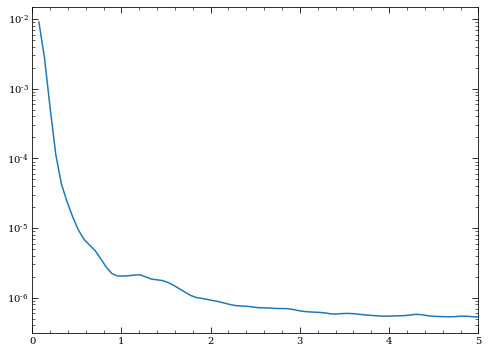

In [24]:
plt.semilogy(curves[0][0],curves[0][1])
plt.xlim(0,5)
